<h1>MNIST dataset classification<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation</a></span><ul class="toc-item"><li><span><a href="#Classification" data-toc-modified-id="Classification-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Classification</a></span></li></ul></li><li><span><a href="#Data-transformation" data-toc-modified-id="Data-transformation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data transformation</a></span></li><li><span><a href="#Dataset-creation" data-toc-modified-id="Dataset-creation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dataset creation</a></span></li><li><span><a href="#Split-for-train,-val-and-test-data" data-toc-modified-id="Split-for-train,-val-and-test-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Split for train, val and test data</a></span></li><li><span><a href="#Dataloader-creation" data-toc-modified-id="Dataloader-creation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Dataloader creation</a></span></li><li><span><a href="#Model-creation" data-toc-modified-id="Model-creation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Model creation</a></span><ul class="toc-item"><li><span><a href="#Model-train" data-toc-modified-id="Model-train-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Model train</a></span></li></ul></li></ul></div>

In [1]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision.transforms import v2

import os
import matplotlib.pyplot as plt
import numpy as np

import json
from tqdm import tqdm
from PIL import Image

import struct
import sys
from array import array
from os import path

from matplotlib.ticker import AutoMinorLocator, MultipleLocator

In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

## Data preparation

### Classification

In [3]:
def read(dataset):
    if dataset == 'training':
        path_img = '/Users/alexeyfilichkin/Desktop/PyTorch/MNIST/mnist/MNIST/raw/train-images-idx3-ubyte'
        path_lbl = '/Users/alexeyfilichkin/Desktop/PyTorch/MNIST/mnist/MNIST/raw/train-labels-idx1-ubyte'
    
    elif dataset == 'testing':
        path_img = '/Users/alexeyfilichkin/Desktop/PyTorch/MNIST/mnist/MNIST/raw/t10k-images-idx3-ubyte'
        path_lbl = '/Users/alexeyfilichkin/Desktop/PyTorch/MNIST/mnist/MNIST/raw/t10k-labels-idx1-ubyte'
    
    else:
        raise ValueError('dataset must be training or testing')
    
    with open(path_lbl, 'rb') as f_lable:
        _, size = struct.unpack('>II', f_lable.read(8))
        lbl = array('b', f_lable.read())
        
    with open(path_img, 'rb') as f_img:
        _, size, rows, cols = struct.unpack('>IIII', f_img.read(16))
        img = array('B', f_img.read())
    
    return lbl, img, size, rows,cols

def write_dataset(labels, data, size, rows,cols, output_dir):
    
    classes = {i: f'class_{i}' for i in range(10)}
    
    output_dirs = [
        path.join(output_dir, classes[i])
        for i in range(10)
    ]
    
    for d in output_dirs:
        if not path.exists(d):
            os.makedirs(d)
    
    for i, label in enumerate(labels):
        output_filename = path.join(output_dirs[label], str(i) + '.jpg')
#        print('writing' + output_filename)
        
        with open(output_filename, 'wb') as h:
            data_i = [
                data[(i*rows*cols + j*cols) : (i*rows*cols + (j+1)*cols)]
                for j in range(rows)
            ]
            data_array = np.asarray(data_i)
            
            im = Image.fromarray(data_array)
            im.save(output_filename)        

In [4]:
train_dataset = torchvision.datasets.MNIST(
    root='/Users/alexeyfilichkin/Desktop/PyTorch/MNIST/mnist', train=True, download=True)
test_dataset = torchvision.datasets.MNIST(
    root='/Users/alexeyfilichkin/Desktop/PyTorch/MNIST/mnist', train=False, download=True)

In [5]:
output_path = '/Users/alexeyfilichkin/Desktop/PyTorch/MNIST/mnist'

In [6]:
for dataset in tqdm(['training', 'testing']):
    write_dataset(*read(dataset), path.join(output_path, dataset))

100%|█████████████████████████████████████████████| 2/2 [00:13<00:00,  6.64s/it]


## Data transformation

In [7]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.5,), std=(0.5,))
])

## Dataset creation

In [8]:
class MNISTDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        
        self.len_dataset = 0
        self.data_list = []
        
        for path_dir, dir_list, file_list in os.walk(path):
            if path_dir == path:
                self.classes = sorted(dir_list)
                self.class_to_idx = {
                    cls_name: i for i, cls_name in enumerate(self.classes)
                    }
                continue
        
            cls = path_dir.split('/')[-1]
        
            for name_file in file_list:
                file_path = os.path.join(path_dir, name_file)
                self.data_list.append((file_path, self.class_to_idx[cls]))
        
            self.len_dataset += len(file_list)
    
    def __len__(self):
        return self.len_dataset
    
    def __getitem__(self, index):
        file_path, target = self.data_list[index]
        sample = Image.open(file_path)
        
        if self.transform is not None:
            sample = self.transform(sample)
        
        return sample, target    

In [9]:
train_data = MNISTDataset('/Users/alexeyfilichkin/Desktop/PyTorch/MNIST/mnist/training',
                         transform=transform)
test_data = MNISTDataset('/Users/alexeyfilichkin/Desktop/PyTorch/MNIST/mnist/testing',
                        transform=transform)

In [10]:
print(len(train_data))
print(len(test_data))

60000
10000


In [11]:
train_data.classes

['class_0',
 'class_1',
 'class_2',
 'class_3',
 'class_4',
 'class_5',
 'class_6',
 'class_7',
 'class_8',
 'class_9']

In [12]:
train_data.class_to_idx

{'class_0': 0,
 'class_1': 1,
 'class_2': 2,
 'class_3': 3,
 'class_4': 4,
 'class_5': 5,
 'class_6': 6,
 'class_7': 7,
 'class_8': 8,
 'class_9': 9}

In [13]:
for cls, one_hot_position in train_data.class_to_idx.items():
    one_hot_vector = [(i == one_hot_position)*1 for i in range(10)]
    print(f'{cls} => {one_hot_vector}')

class_0 => [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
class_1 => [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
class_2 => [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
class_3 => [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
class_4 => [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
class_5 => [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
class_6 => [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
class_7 => [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
class_8 => [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
class_9 => [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


class class_4


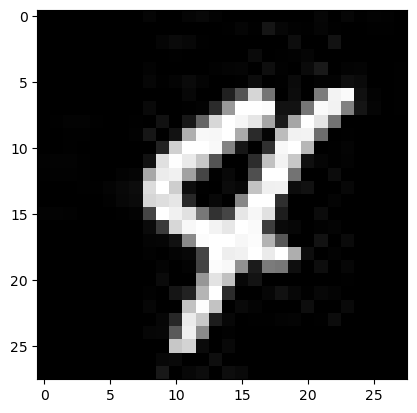

In [14]:
img, one_hot_position = train_data[5555]
cls = train_data.classes[one_hot_position]
print(f'class {cls}')
plt.imshow(img.permute(1, 2, 0), cmap='gray');

In [15]:
img, cl = test_data[10]

print(f'Img class: {cl}')
print(f'Img type: {type(img)}')
print(f'Data shape: {img.shape}')
print(f'Data type: {img.dtype}')
print(f'Img min: {img.min()}, Img max: {img.max()}')

Img class: 4
Img type: <class 'torchvision.tv_tensors._image.Image'>
Data shape: torch.Size([1, 28, 28])
Data type: torch.float32
Img min: -1.0, Img max: 1.0


## Split for train, val and test data

In [16]:
train_data, val_data = random_split(train_data, [0.8, 0.2])

In [17]:
print(f'Train data {len(train_data)}')
print(f'Validation data {len(val_data)}')
print(f'Test data {len(test_data)}')

Train data 48000
Validation data 12000
Test data 10000


## Dataloader creation

In [18]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [19]:
imgs, cl = next(iter(train_loader))

print('Image:')
print(f'Img type: {type(imgs)}')
print(f'Data shape: {imgs.shape}')
print(f'Data type: {imgs.dtype}')

print('Class:')
print(f'Class type: {type(cl)}')
print(f'Class shape: {cl.shape}')
print(f'Class data type: {cl.dtype}')

Image:
Img type: <class 'torch.Tensor'>
Data shape: torch.Size([16, 1, 28, 28])
Data type: torch.float32
Class:
Class type: <class 'torch.Tensor'>
Class shape: torch.Size([16])
Class data type: torch.int64


## Model creation

In [46]:
class MyModel(nn.Module):
    def __init__(self, inp, out):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(inp, 32, (3, 3), bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, (3, 3), bias=False),
            nn.ReLU()
        )
        
        self.flatten = nn.Flatten()
        
        self.fc = nn.Sequential(
            nn.Linear(64*24*24, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, out)
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        output = self.fc(x)
        return output

In [47]:
model = MyModel(1, 10).to(device)

In [48]:
inp = torch.rand([16, 1, 28, 28], dtype=torch.float32).to(device)

In [49]:
out = model(inp)

In [50]:
out.shape

torch.Size([16, 10])

### Model train

In [51]:
loss_model = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [52]:
EPOCHS = 20
train_loss = []
train_acc = []
val_loss = []
val_acc = []

In [53]:
for epoch in range(1, EPOCHS+1):
    
    model.train()
    running_train_loss = []
    true_answer = 0
    
    train_loop = tqdm(train_loader, leave=False)
    for x, targets in train_loop:
        x = x.to(device)
#        x = x.reshape(-1, 28*28).to(device)
        
        targets = targets.reshape(-1).to(torch.int32)
        targets = torch.eye(10)[targets].to(device)
        
        pred = model(x)
        loss = loss_model(pred, targets)
        
        opt.zero_grad()
        loss.backward()
        
        opt.step()
        
        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss) / len(running_train_loss)
        
        true_answer += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()
        train_loop.set_description(f'Epoch [{epoch} / {EPOCHS}], train_loss={mean_train_loss:.4f}')
    
    running_train_acc = true_answer / len(train_data)
    
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_acc)
    
    model.eval()
    with torch.no_grad():
        running_val_loss = []
        true_answer = 0
        
        for x, targets in val_loader:
            x = x.to(device)
#            x = x.reshape(-1, 28*28).to(device)
            
            targets = targets.reshape(-1).to(torch.int32)
            targets = torch.eye(10)[targets].to(device)
            
            pred = model(x)
            loss = loss_model(pred, targets)
            
            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss) / len(running_val_loss)
            
            true_answer += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()
            
        running_val_acc = true_answer / len(val_data)
        
        val_loss.append(mean_val_loss)
        val_acc.append(running_val_acc)
        
        if epoch == 1 or epoch % 5 == 0:
            print(f'Epoch [{epoch} / {EPOCHS}], train_loss={mean_train_loss:.4f},'
                  f'train_acc={running_train_acc:.4f}, val_loss={mean_val_loss:.4f},'
                  f'val_acc={running_val_acc:.4f}')  

Epoch [1 / 20], train_loss=0.2057,train_acc=0.9385, val_loss=0.0727,val_acc=0.9769


Epoch [5 / 20], train_loss=0.0410,train_acc=0.9875, val_loss=0.0564,val_acc=0.9870


Epoch [10 / 20], train_loss=0.0183,train_acc=0.9944, val_loss=0.0623,val_acc=0.9871


Epoch [15 / 20], train_loss=0.0128,train_acc=0.9960, val_loss=0.0889,val_acc=0.9872


Epoch [20 / 20], train_loss=0.0113,train_acc=0.9964, val_loss=0.0860,val_acc=0.9884


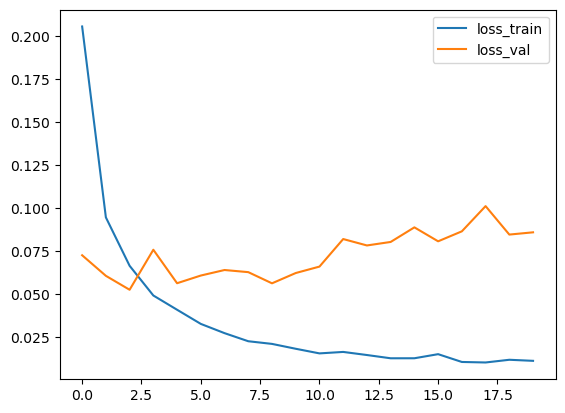

In [54]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['loss_train', 'loss_val'])
plt.show()

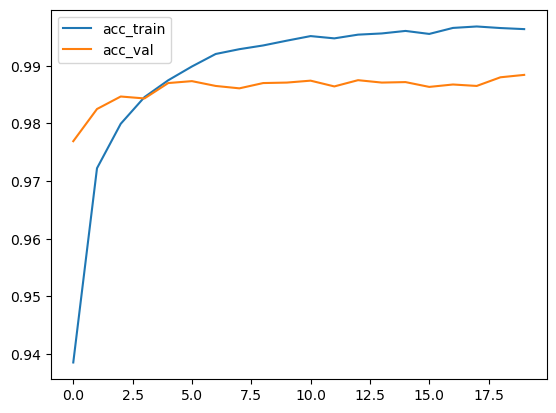

In [55]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['acc_train', 'acc_val'])
plt.show()